In [120]:
# import necessary modules
import pandas as pd
pd.options.display.max_columns=1000
pd.options.display.width=200
pd.options.display.min_rows=60
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score
from sklearn import preprocessing
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree

from datetime import datetime

In [79]:
def preprocess_data(df):
    '''
    function to remove non-numeric features and null values
    input: dataframe
    outputs: df & var_class=Series with class labels popped from df
    '''
    
    #select only columns with int or float data types
    df = df.select_dtypes(['number'])
    #drop any columns with null values
    df.dropna(axis=1,inplace=True)
    #remove the class series
    var_class = df.pop('CLASS')
    
    return df, var_class


In [80]:
def compare_dicts(a,b,ignore=['test_score','train_score','tn','fn','tp','fp','f1_score','precision','recall']):
    a = dict(a)
    b = dict(b)
    for k in ignore:
        a.pop(k,None)
        b.pop(k,None)
        
    return tuple(a.items()) == tuple(b.items())

In [81]:
def make_comparison(hyperparam_table, hyper_dict, compare_func=compare_dicts):
    '''
    function to compare current hyperparameters (hyper_dict) to existing hyperparam_table
    inputs: hyperparam_table, hyper_dict
    outputs: exists=True if hyper_dict has been run before and False if it hasn't & hyper_dict
    '''
    
    exists = any([compare_func(a, b=hyper_dict) for a in hyperparam_table])
    return exists, hyper_dict
    

In [82]:
def train_test_write(x_train,x_test,y_train,y_test, filename, scaled=False):
    '''
    function to write train and test sets to files
    inputs: train and test dfs & scaled=False if no scaling, True if scaling
    output: None
    '''
    
    if scaled:
        x_train.to_csv(filename[:-4]+'_scaledxtrain.csv')
        x_test.to_csv(filename[:-4]+'_scaledxtest.csv')
        y_train.to_csv(filename[:-4]+'_scaledytrain.csv',header=False)
        y_test.to_csv(filename[:-4]+'_scaledytest.csv',header=False)
    else:
        x_train.to_csv(filename[:-4]+'_xtrain.csv')
        x_test.to_csv(filename[:-4]+'_xtest.csv')
        y_train.to_csv(filename[:-4]+'_ytrain.csv',header=False)
        y_test.to_csv(filename[:-4]+'_ytest.csv',header=False)

In [83]:
def train_model(x_train, y_train, x_test, y_test, hyper_dict, hyperparam_table):
    '''
    function to train model with given training/test sets and hyperparameters
    inputs: x_train, y_train, x_test, y_test, hyper_dict=dict of current hyperparameters to be run, hyperparam_table=table of hyperparameters already run
    outputs: clf=classifier trained & hyperparam_table updated
    '''
    
    hyperparam_table += [hyper_dict]
    clf = hyper_dict['model'](class_weight=hyper_dict['class_weight'], random_state=hyper_dict['random_state'])
    clf.fit(x_train, y_train)
    
    predictions_test = clf.predict(x_test)
    predictions_train = clf.predict(x_train)
    
    score = clf.score(x_test,y_test)
    hyperparam_table[-1]['test_score'] = score
    training_score = clf.score(x_train,y_train)
    hyperparam_table[-1]['train_score'] = training_score
    
    tn, fp, fn, tp = confusion_matrix(y_test,predictions_test).ravel()
    hyperparam_table[-1]['tn'] = tn
    hyperparam_table[-1]['fp'] = fp
    hyperparam_table[-1]['fn'] = fn
    hyperparam_table[-1]['tp'] = tp
    
    f1 = f1_score(y_test,predictions_test)
    hyperparam_table[-1]['f1_score'] = f1
    precision = precision_score(y_test,predictions_test)
    hyperparam_table[-1]['precision'] = precision
    recall = recall_score(y_test,predictions_test)
    hyperparam_table[-1]['recall'] = recall
    
    hyperparam_table[-1]['feature_importances'] = clf.feature_importances_
    
    return clf, hyperparam_table

In [84]:
# create empty hyperparameter table
hyperparam_table = []

In [85]:
# run a Decision Tree model on raw data before any data cleaning/feature engineering
filename = 'data/clinvar_conflicting.csv'
df =  pd.read_csv(filename)
df, var_class = preprocess_data(df)

hyper_dict = {'test_size': 0.05, 
              'random_state': 0, 
              'data_size': str(df.shape),
              'scaling': None,
              'filename': filename,
              'model': DecisionTreeClassifier,
              'class_weight': None
             }

x_train, x_test, y_train, y_test = train_test_split(df,var_class,
                                                 test_size=hyper_dict['test_size'],
                                                 random_state=hyper_dict['random_state'])

train_test_write(x_train,x_test,y_train,y_test, filename, scaled=False)
exists, hyper_dict = make_comparison(hyperparam_table, hyper_dict, compare_func=compare_dicts)
if not exists: 
    clf, hyperparam_table = train_model(x_train, y_train, x_test, y_test, hyper_dict, hyperparam_table)


/home/gksullan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/gksullan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [86]:
# looks like data is imbalanced, let's balance class_weight in the model
filename = 'data/clinvar_conflicting.csv'
df =  pd.read_csv(filename)
df, var_class = preprocess_data(df)

hyper_dict = {'test_size': 0.05, 
              'random_state': 0, 
              'data_size': str(df.shape),
              'scaling': None,
              'filename': filename,
              'model': DecisionTreeClassifier,
              'class_weight': 'balanced'
             }

x_train, x_test, y_train, y_test = train_test_split(df, var_class,
                                                 test_size=hyper_dict['test_size'],
                                                 random_state=hyper_dict['random_state'])
train_test_write(x_train, x_test, y_train, y_test, filename, scaled=False)
exists, hyper_dict = make_comparison(hyperparam_table, hyper_dict, compare_func=compare_dicts)
if not exists: 
    clf, hyperparam_table = train_model(x_train, y_train, x_test, y_test, hyper_dict, hyperparam_table)


/home/gksullan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/gksullan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [87]:
# convert the hyperparam_table to dataframe and visualize
df_hyp = pd.DataFrame(hyperparam_table)
df_hyp.head(10)

,test_size,random_state,data_size,scaling,filename,model,class_weight,test_score,train_score,tn,fp,fn,tp,f1_score,precision,recall,feature_importances
0,0.05,0,"(65188, 4)",None,data/clinvar_conflicting.csv,<class 'sklearn.tree.tree.DecisionTreeClassifi...,None,0.693865,0.991862,1940,482,516,322,0.392205,0.400498,0.384248,"[0.5980214557934986, 0.09421548420009841, 0.19..."
1,0.05,0,"(65188, 4)",None,data/clinvar_conflicting.csv,<class 'sklearn.tree.tree.DecisionTreeClassifi...,balanced,0.695706,0.990570,1938,484,508,330,0.399516,0.405405,0.393795,"[0.6009555559971032, 0.08926719893875158, 0.18..."


In [88]:
# final dataset: cleaned data with additional engineering NLP features for the REF and ALT alleles
filename = 'data/data_cleanednlp4.csv'
df =  pd.read_csv(filename)
df, var_class = preprocess_data(df)

hyper_dict = {'test_size': 0.05, 
              'random_state': 0, 
              'data_size': str(df.shape),
              'scaling': None,
              'filename': filename,
              'model': DecisionTreeClassifier,
              'class_weight': 'balanced'
             }

x_train, x_test, y_train, y_test = train_test_split(df, var_class,
                                                 test_size=hyper_dict['test_size'],
                                                 random_state=hyper_dict['random_state'])
train_test_write(x_train, x_test, y_train, y_test, filename)
exists, hyper_dict = make_comparison(hyperparam_table, hyper_dict)
if not exists: 
    clf, hyperparam_table = train_model(x_train, y_train, x_test, y_test, hyper_dict, hyperparam_table)


/home/gksullan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (34,36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/gksullan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [89]:
# convert the hyperparam_table to dataframe and visualize
df_hyp = pd.DataFrame(hyperparam_table)
df_hyp.head(10)

,test_size,random_state,data_size,scaling,filename,model,class_weight,test_score,train_score,tn,fp,fn,tp,f1_score,precision,recall,feature_importances
0,0.05,0,"(65188, 4)",None,data/clinvar_conflicting.csv,<class 'sklearn.tree.tree.DecisionTreeClassifi...,None,0.693865,0.991862,1940,482,516,322,0.392205,0.400498,0.384248,"[0.5980214557934986, 0.09421548420009841, 0.19..."
1,0.05,0,"(65188, 4)",None,data/clinvar_conflicting.csv,<class 'sklearn.tree.tree.DecisionTreeClassifi...,balanced,0.695706,0.990570,1938,484,508,330,0.399516,0.405405,0.393795,"[0.6009555559971032, 0.08926719893875158, 0.18..."
2,0.05,0,"(65188, 61)",None,data/data_cleanednlp4.csv,<class 'sklearn.tree.tree.DecisionTreeClassifi...,balanced,0.697853,1.000000,1945,477,508,330,0.401216,0.408922,0.393795,"[0.13813333574308895, 0.04297086633686263, 0.1..."


In [90]:
# Use RandomSearchCV to find the best hyperparameters for this model

param_dist = {"class_weight": [None, 'balanced'],
              "max_depth": [5, 10, 15, None],
              "max_features": ['sqrt', 'log2', None],
              "min_samples_leaf": np.arange(1, 9),
              "criterion": ["gini", "entropy"]}

# Instantiate a Decision Tree classifier
clf = DecisionTreeClassifier(random_state=0)

# Instantiate the RandomizedSearchCV object
clf_cv = RandomizedSearchCV(clf, param_dist, scoring='balanced_accuracy', cv=5)

# Fit it to the data
clf_cv.fit(x_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=DecisionTreeClassifier(class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort=False,
                                                    random_state=0,
                                                    splitter='best'),
 

In [91]:
# preview the best parameters and score
print(f"Tuned Decision Tree Parameters: {clf_cv.best_params_}")
print(f"Best score is {clf_cv.best_score_}")

Tuned Decision Tree Parameters: {'min_samples_leaf': 1, 'max_features': None, 'max_depth': 10, 'criterion': 'entropy', 'class_weight': 'balanced'}
Best score is 0.6832578695944459


In [92]:
cv_params = clf_cv.best_params_

In [93]:
# Using this model with the best params, predict labels on test data
hyper_dict = {'test_size': 0.05, 
              'random_state': 0, 
              'data_size': str(df.shape),
              'scaling': None,
              'filename': filename,
              'model': DecisionTreeClassifier
             }
clf = DecisionTreeClassifier(random_state=0)
clf.set_params(**cv_params)
hyper_dict.update(cv_params)
hyperparam_table += [hyper_dict]
clf.fit(x_train, y_train)
pred = clf.predict(x_test)
score = clf.score(x_test,y_test)
hyperparam_table[-1]['test_score'] = score
training_score = clf.score(x_train,y_train)
hyperparam_table[-1]['train_score'] = training_score

tn, fp, fn, tp = confusion_matrix(y_test,pred).ravel()
hyperparam_table[-1]['tn'] = tn
hyperparam_table[-1]['fp'] = fp
hyperparam_table[-1]['fn'] = fn
hyperparam_table[-1]['tp'] = tp

f1 = f1_score(y_test,pred)
hyperparam_table[-1]['f1_score'] = f1
precision = precision_score(y_test,pred)
hyperparam_table[-1]['precision'] = precision
recall = recall_score(y_test,pred)
hyperparam_table[-1]['recall'] = recall

hyperparam_table[-1]['feature_importances'] = clf.feature_importances_

In [94]:
df_hyp = pd.DataFrame(hyperparam_table)
df_hyp.head(10)

,test_size,random_state,data_size,scaling,filename,model,class_weight,test_score,train_score,tn,fp,fn,tp,f1_score,precision,recall,feature_importances,min_samples_leaf,max_features,max_depth,criterion
0,0.05,0,"(65188, 4)",None,data/clinvar_conflicting.csv,<class 'sklearn.tree.tree.DecisionTreeClassifi...,None,0.693865,0.991862,1940,482,516,322,0.392205,0.400498,0.384248,"[0.5980214557934986, 0.09421548420009841, 0.19...",NaN,NaN,NaN,NaN
1,0.05,0,"(65188, 4)",None,data/clinvar_conflicting.csv,<class 'sklearn.tree.tree.DecisionTreeClassifi...,balanced,0.695706,0.990570,1938,484,508,330,0.399516,0.405405,0.393795,"[0.6009555559971032, 0.08926719893875158, 0.18...",NaN,NaN,NaN,NaN
2,0.05,0,"(65188, 61)",None,data/data_cleanednlp4.csv,<class 'sklearn.tree.tree.DecisionTreeClassifi...,balanced,0.697853,1.000000,1945,477,508,330,0.401216,0.408922,0.393795,"[0.13813333574308895, 0.04297086633686263, 0.1...",NaN,NaN,NaN,NaN
3,0.05,0,"(65188, 61)",None,data/data_cleanednlp4.csv,<class 'sklearn.tree.tree.DecisionTreeClassifi...,balanced,0.671779,0.697875,1619,803,267,571,0.516275,0.415575,0.681384,"[0.054550397674179345, 0.02344848809138111, 0....",1.0,NaN,10.0,entropy


- Looking at row 2 of the hyperparameter table, the cleaned dataset `data_cleanednlp4.csv` provides the best performance in accuracy and f1 score. However, the training accuracy of 1 indicates that the model is overfit. 
- After RandomizedSearchCV for hyperparameter tuning, we can see that the gap between training and test accuracy has been closed, making it an overall better fit model with less of a chance of overfitting. Additionally, the f1 score has been improved compared to before hyperparameter tuning. 
- Compared to the best logistic regression model, this model offers an improved f1_score as well as test accuracy

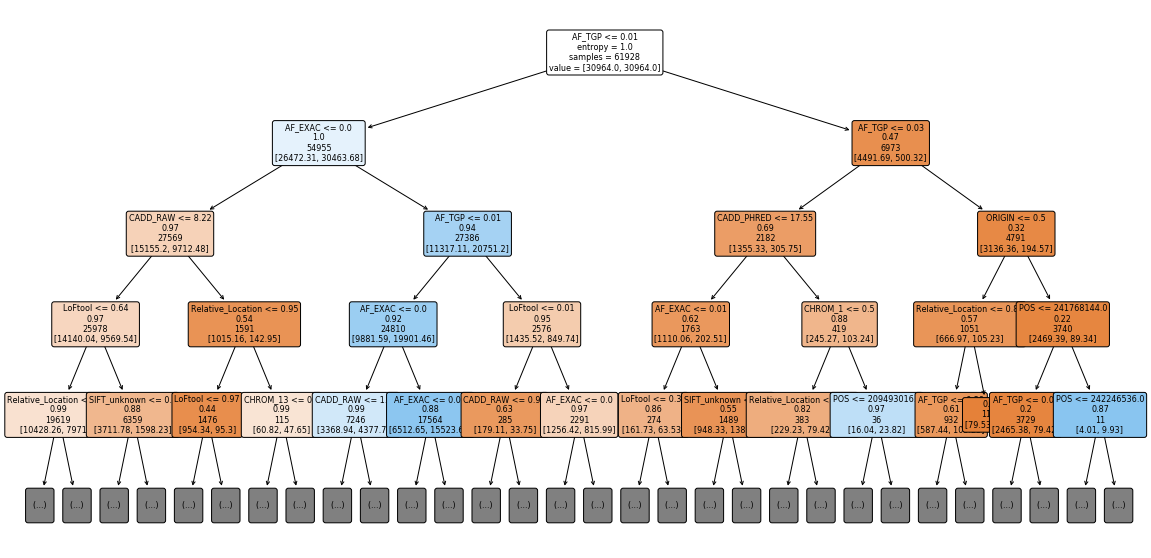

In [121]:
# visualize the decision tree to depth 4 

plt.figure(figsize=(20,10))
_ = plot_tree(clf, filled=True, fontsize=8, label='root', max_depth=4, precision=2, rounded=True, feature_names=list(df.columns))
plt.show()

In [118]:
# save the hyperparameter table to a .pickle file
time = datetime.now().strftime("%Y%m%d_%H:%M:%S")
filename = 'hyperparameter_tables/hyperparameter_table'+time+'.pkl'
df_hyp.to_pickle(filename)